In [36]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

In [4]:
images_train_directory = '../images/ic/train'
images_val_directory = '../images/ic/validation'
images_test_directory = '../images/ic/test'

batch_size = 32
img_size = (256, 256)

In [6]:
class_names = ['incorrect', 'correct']

train_ds = tf.keras.utils.image_dataset_from_directory(
  images_train_directory,
  class_names=class_names,
  seed=123,
  image_size=img_size,
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  images_val_directory,
  class_names=class_names,
  shuffle=False,
  image_size=img_size,
  batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  images_test_directory,
  class_names=class_names,
  shuffle=False,
  image_size=img_size,
  batch_size=batch_size
)     

Found 4001 files belonging to 2 classes.
Found 868 files belonging to 2 classes.
Found 941 files belonging to 2 classes.


In [7]:
ic_model = tf.keras.models.Sequential([
    # data_augmentation,
    tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3042, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2028, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1014, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.001,
  decay_steps=10000,
  decay_rate=0.9
  )

ic_model.compile(
  loss='binary_crossentropy',
  optimizer=tf.optimizers.SGD(learning_rate=lr_schedule),
  metrics=['accuracy'],
)

ic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

In [9]:
ic_model.evaluate(val_ds)

28/28 [==============================] - 2s 58ms/step - loss: 0.6967 - accuracy: 0.3318


[0.6967304348945618, 0.3317972421646118]

In [10]:
ic_model.load_weights('./models/ic_model_w_v4.h5')

In [11]:
ic_model.evaluate(val_ds)

28/28 [==============================] - 2s 59ms/step - loss: 0.1269 - accuracy: 0.9516


[0.12691301107406616, 0.9516128897666931]

In [25]:
ic_validations_labels = np.array(list(map(lambda x: x[1], val_ds.unbatch().as_numpy_iterator())))
ic_predictions = ic_model.predict(val_ds).reshape(-1)

28/28 [==============================] - 2s 80ms/step


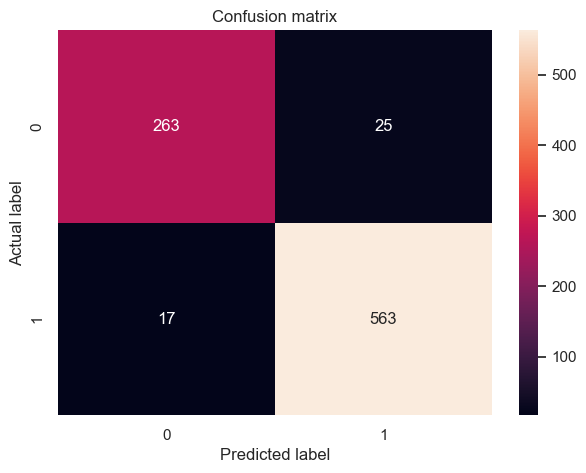

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# confusion matrix
ic_cm_old = confusion_matrix(ic_validations_labels, ic_predictions > 0.5)

sns.heatmap(ic_cm_old, annot=True, fmt="d", ax=ax)
ax.set_ylabel('Actual label')
ax.set_xlabel('Predicted label')
ax.set_title("Confusion matrix")

plt.show()

In [29]:
np.array([ic_validations_labels, ic_predictions]).T

array([[1.        , 0.99854648],
       [1.        , 0.99116933],
       [1.        , 0.99933219],
       ...,
       [0.        , 0.00953283],
       [0.        , 0.01437563],
       [0.        , 0.03542317]])

In [35]:
ic_preds_1 = ic_predictions > 0.5
ic_prediction_1 = ic_predictions[ic_preds_1]  # get the probs predictions from model
ic_pred_label = np.where(ic_prediction_1 > 0.5, 1, 0)  # get the labels from probs
ic_true_1 = ic_validations_labels[ic_preds_1]  # get the true values for predictions
ic_errors_1 = np.where(ic_pred_label != ic_true_1, True, False) # get the errors
ic_errors_1_images = np.array(val_ds.file_paths)[ic_preds_1][ic_errors_1]  # get the images that are errors

(25, 1)
(563, 1)


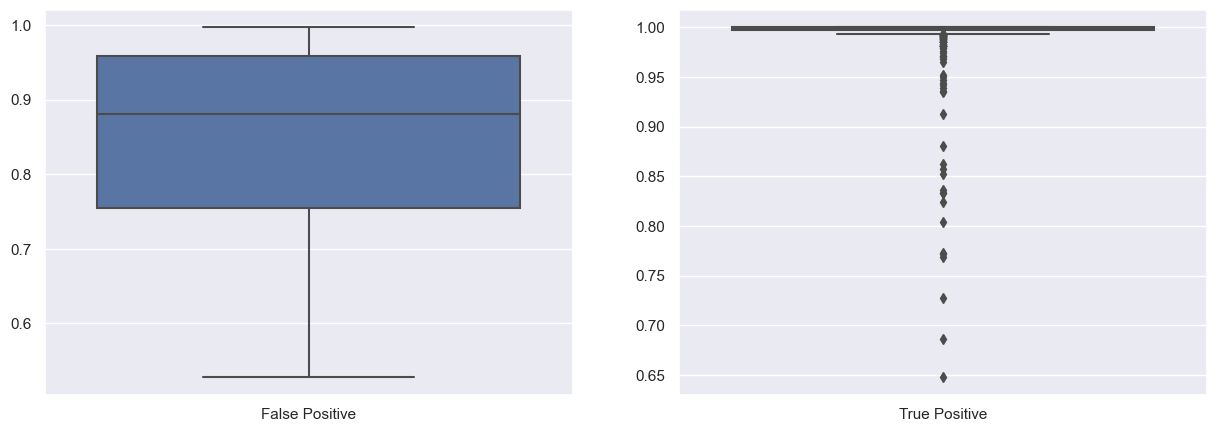

In [37]:
error_df = pd.DataFrame(ic_prediction_1[ic_errors_1], columns=['False Positive'])
correct_df = pd.DataFrame(ic_prediction_1[~ic_errors_1], columns=['True Positive'])
print(error_df.shape)
print(correct_df.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=error_df, orient='v', ax=ax[0])
sns.boxplot(data=correct_df, orient='v', ax=ax[1])
plt.show()

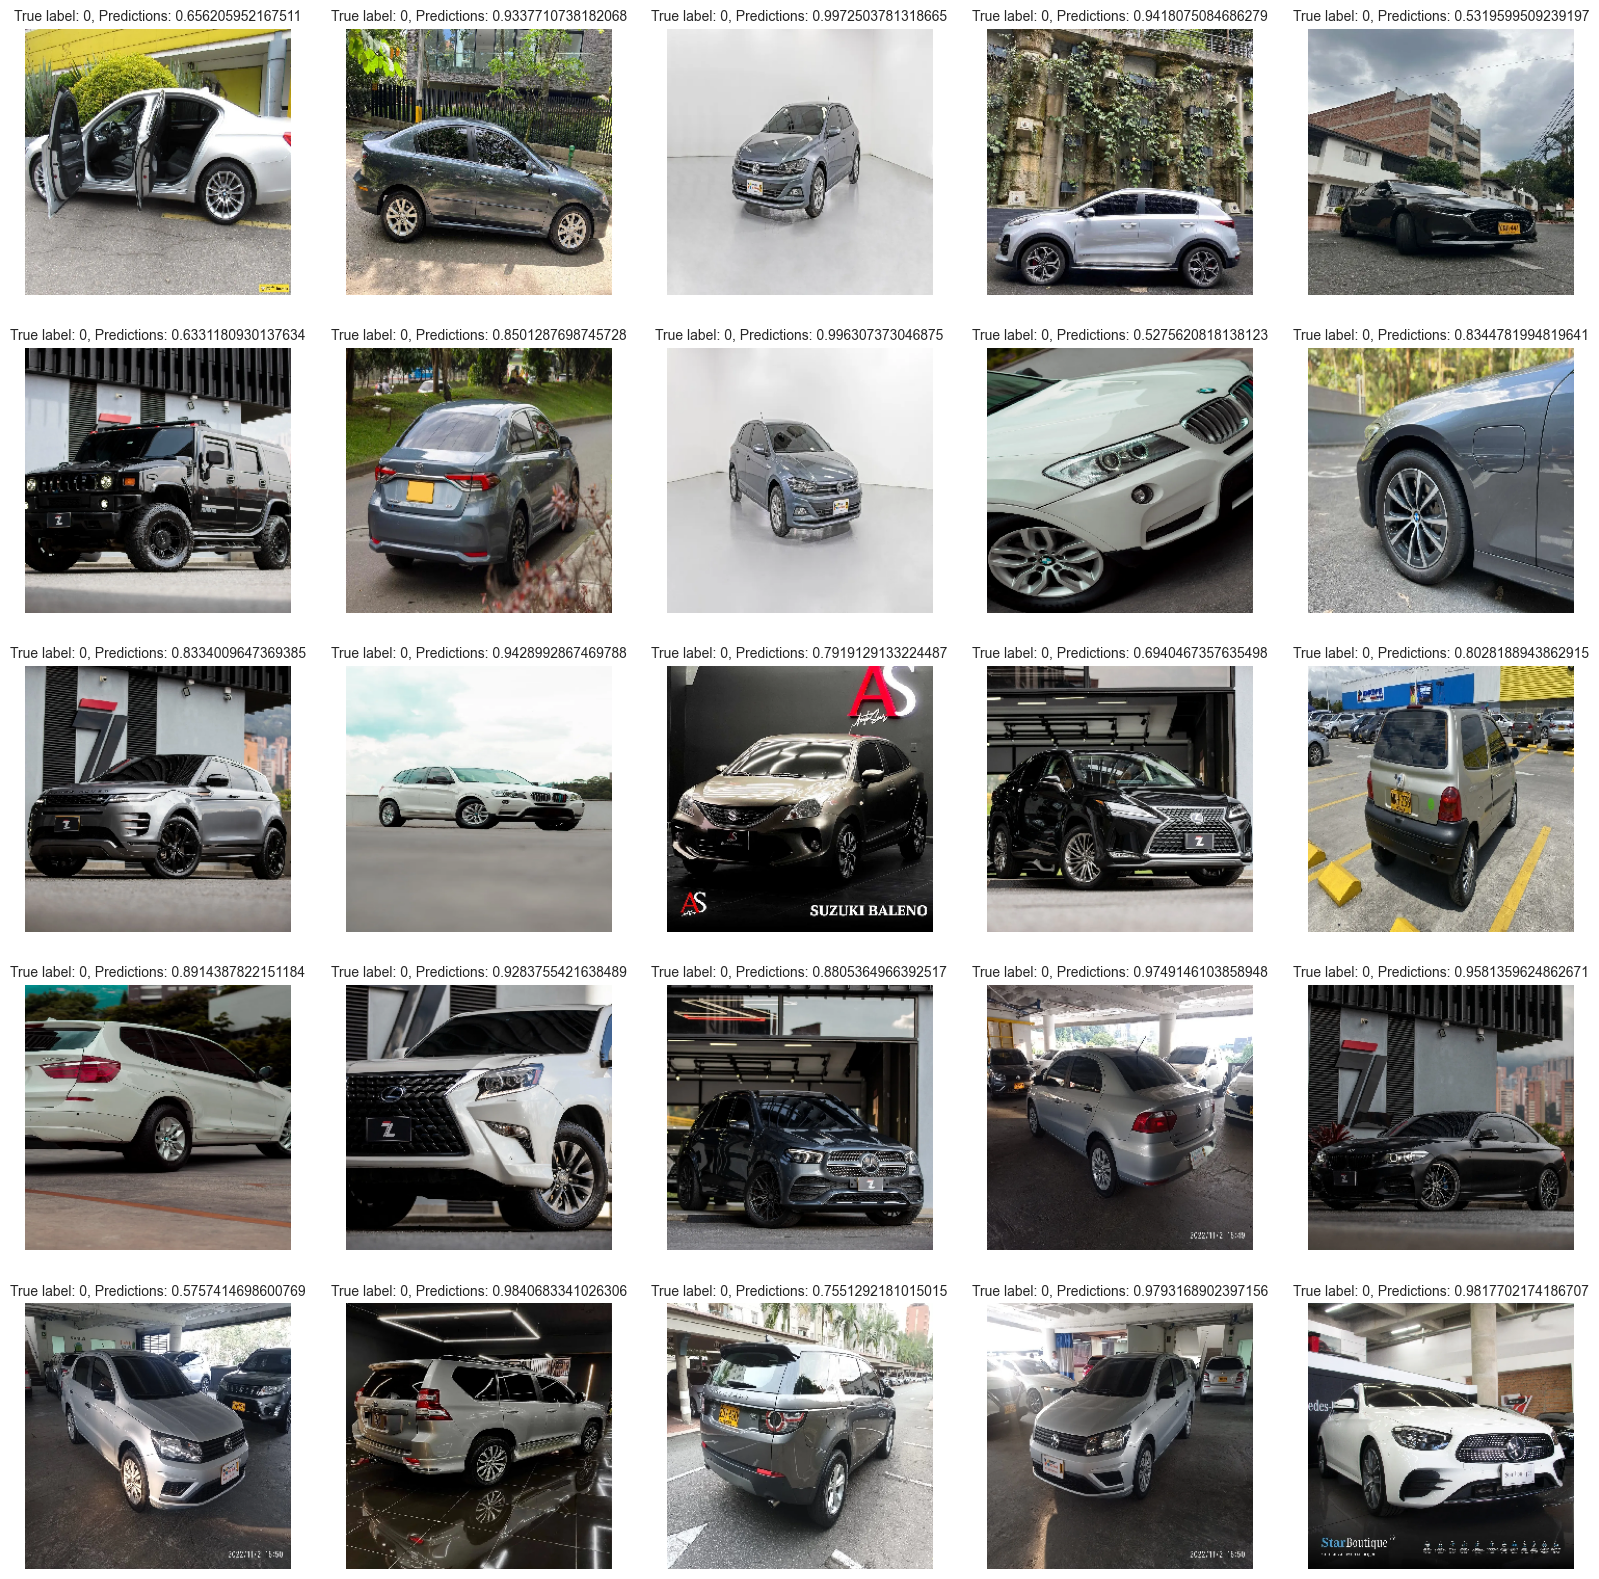

In [38]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for i, ax in enumerate(fig.axes):
  try:
    error_image = tf.keras.preprocessing.image.load_img(ic_errors_1_images[i])
    ax.imshow(error_image)
    ax.axis('off')
    ax.set_title(f'True label: {ic_true_1[ic_errors_1][i]}, Predictions: {ic_prediction_1[ic_errors_1][i]}', fontsize=10)
  except IndexError:
    continue
plt.show()

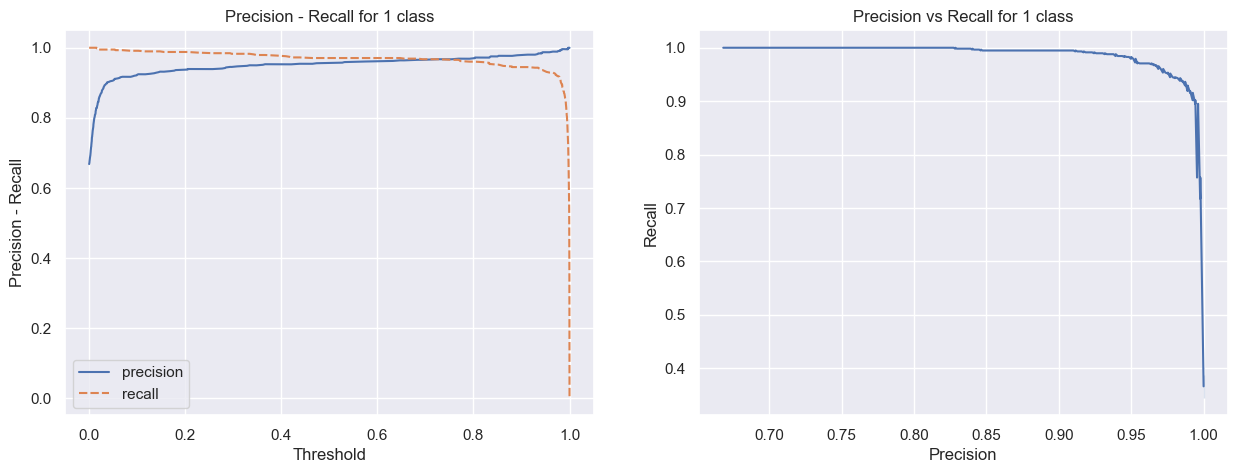

In [41]:
precision, recall, thresholds = precision_recall_curve(ic_validations_labels, ic_predictions)
prt = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1]}, index=thresholds)
# prt = prt[(prt.index <= 0.999)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(data=prt, ax=ax[0])
ax[0].set_ylabel('Precision - Recall')
ax[0].set_xlabel('Threshold')
ax[0].set_title(f'Precision - Recall for 1 class')

sns.lineplot(x='precision', y='recall', data=prt, ax=ax[1])
ax[1].set_ylabel('Recall')
ax[1].set_xlabel('Precision')
ax[1].set_title(f'Precision vs Recall for 1 class')
plt.show()

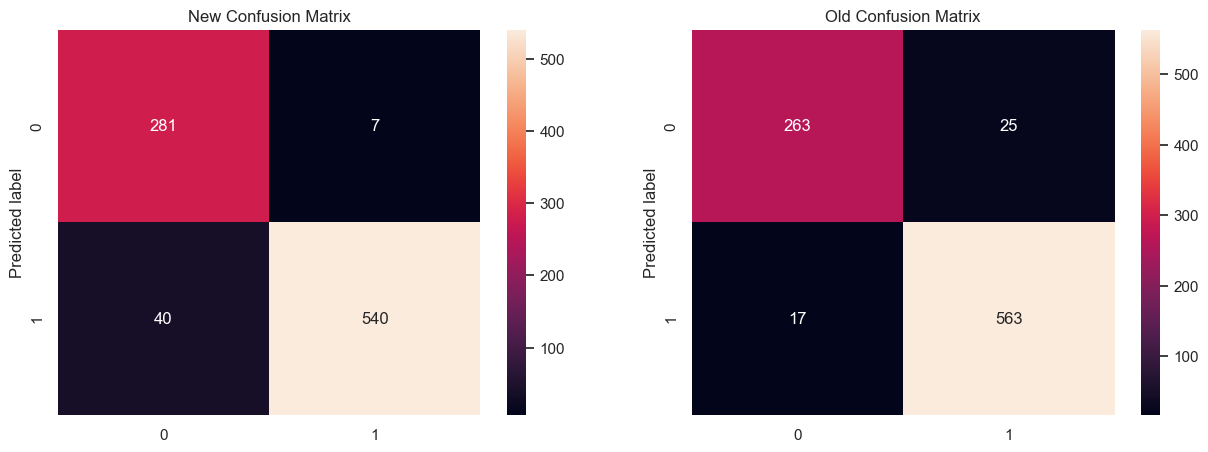

In [46]:
new_label_predictions = np.zeros(ic_predictions.shape)
thresholld = 0.95
for idx, row in enumerate(ic_predictions):
  new_label_predictions[idx] = 1 if row > thresholld else 0

ic_new_cm = confusion_matrix(ic_validations_labels, new_label_predictions)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(ic_new_cm, annot=True, fmt="d", ax=ax[0])
ax[0].set_title('New Confusion Matrix')
ax[0].set_ylabel('Actual label')
ax[0].set_ylabel('Predicted label')

sns.heatmap(ic_cm_old, annot=True, fmt="d", ax=ax[1])
ax[1].set_title('Old Confusion Matrix')
ax[1].set_ylabel('Actual label')
ax[1].set_ylabel('Predicted label')

plt.show()

In [48]:
ic_model.evaluate(test_ds)

30/30 [==============================] - 3s 67ms/step - loss: 0.1714 - accuracy: 0.9511


[0.1713808923959732, 0.9511158466339111]

In [47]:
ic_test_predictions = ic_model.predict(test_ds)
ic_test_labels = np.array(list(map(lambda x: x[1], test_ds.unbatch().as_numpy_iterator())))
# ic_validations_labels = np.array(list(map(lambda x: x[1], val_ds.unbatch().as_numpy_iterator())))


30/30 [==============================] - 3s 100ms/step


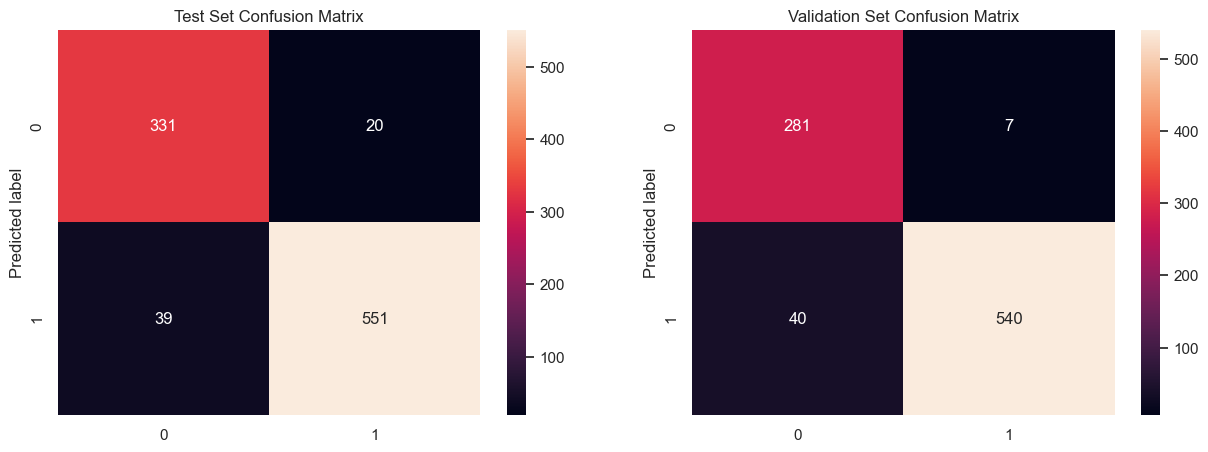

In [49]:
new_label_predictions = np.zeros(ic_test_predictions.shape)
thresholld = 0.95
for idx, row in enumerate(ic_test_predictions):
  new_label_predictions[idx] = 1 if row > thresholld else 0

ic_test_cm = confusion_matrix(ic_test_labels, new_label_predictions)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(ic_test_cm, annot=True, fmt="d", ax=ax[0])
ax[0].set_title('Test Set Confusion Matrix')
ax[0].set_ylabel('Actual label')
ax[0].set_ylabel('Predicted label')

sns.heatmap(ic_new_cm, annot=True, fmt="d", ax=ax[1])
ax[1].set_title('Validation Set Confusion Matrix')
ax[1].set_ylabel('Actual label')
ax[1].set_ylabel('Predicted label')

plt.show()

In [62]:
img = tf.keras.preprocessing.image.load_img('carrr.jpeg', target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
pred = ic_model.predict(img_array.reshape(1, 256, 256, 3))[0]
print(pred)

1/1 [==============================] - 0s 15ms/step
[0.01678114]


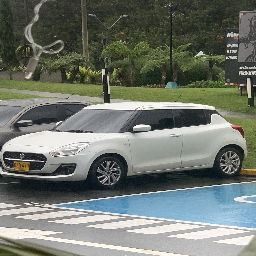

In [63]:
img